# Graph exploration & analysis

--------------

## Preliminaries

- ### Objective :

Predict the virality of memes/hashtags in a social network (Twitter).

- ### Context and motivations :

Virality is, in social networks, an important issue for corporations, political campaigns and influencers as they spend enormous resources and efforts to make their products or messages go viral in order to catch attention and spread their influence/activities to a wider audience.
Thus, understanding the complex mechanism of virality may help one control its effects over the network:
- How does the network structure affect the diffusion? 
- How to model the contagion, etc.

Proposal brought by the paper : the  broad idea is that network communities allow predict virality by its early spreading pattern. A simple, popular approach in studying hashtags diffusion is to consider hashtags as diseases and apply epidemic models. However, recent studies demonstrate that diseases and behaviors spread differently.
We can see huge potentiality for applications in social media marketing : social networks could give better advice to their users as to which posts are likely to give best advertising Return on Investment.


- ### Imports

In [1]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from itertools import product
from itertools import permutations
%matplotlib inline

## I. Data exploration

**** CITATION ****
Please cite our paper as follows, when you are using our dataset:
Lilian Weng, Filippo Menczer, and Yong-Yeol Ahn. Virality Prediction and Community Structure in Social Networks. Nature Scientific Report. (3)2522, 2013.



**** DATA SOURCE ****
Sampled public tweets from Twitter streaming API (https://dev.twitter.com/docs/streaming-apis).
Date range: March 24, 2012 to April 25, 2012.



**** NETWORKS ****
follower_gcc.anony.dat:
    Format: anony.user1.ID anony.user2.ID
    Anonymized reciprocal follower network.
    Each edge is a pair of Twitter user who are following each other. After recovering the reciprocal follower network, the giant connected component is extracted.

retweet_gcc.anony.dat:
    Format: anony.user1.ID anony.user2.ID weight
    Anonymized reciprocal retweet network.
    Similarly to follower_gcc.anony.dat, but instead each edge is a pair of users who retweeted each other at least once during our observation time window. Weight is the sum of how many times user1 retweeted user2 or user2 retweeted user1.

mention_gcc.anony.dat:
    Format: anony.user1.ID anony.user2.ID weight
    Anonymized reciprocal retweet network.
    Similarly to follower_gcc.anony.dat, but instead each edge is a pair of users who mentioned each other at least once during our observation time window. Weight is the sum of how many times user1 mentioned user2 or user2 mentioned user1.



**** HASHTAG SEQUENCES ****
timeline_tag.anony.dat
    Format: hashtag timestamp1,anony.user1.id timestamp2,anony.user2.id ...
    Each line is a hashtag followed by the sequence of its adopters sorted by timestamp. A user is considered as an adopter of a hashtag once he/she starts using the hashtag. We only consider users who appear in the collected networks. The timestamp is the time when we see the hashtag in the user's tweets. The file includes both emergent hashtags and non-emergent ones.

timeline_tag_rt.anony.dat
    Format: hashtag timestamp1,anony.retweet_user1.id,anony.retweet_from_user1.id timestamp2,anony.retweet_user2.id,anony.tweet_from_user2.id ...
    Each line is a hashtag followed by the sequence of its adopters retweeting about this hashtag from other users sorted by timestamp. A "retweet_user" retweets a message containing the hashtag from a "retweet_from_user". We only consider users who appear in the collected networks. The file includes both emergent hashtags and non-emergent ones.

timeline_tag_men.anony.dat
    Format: hashtag timestamp1,anony.mention_user1.id,anony.mentioned_user1.id timestamp2,anony.mention_user2.id,anony.mentioned_user2.id ...
    Each line is a hashtag followed by the sequence of its adopters mentioning other users in messages containing this hashtags sorted by timestamp. A "mention_user" mentions a "mentioned_user" in a message with the target hashtag. We only consider users who appear in the collected networks. The file includes both emergent hashtags and non-emergent ones.



** Note that users in these networks and timeline sequencies are anonymized in the same way so that the same IDs refer to the same Twitter users.

In [4]:
#load from raw dat file into dataframes
    #for relationships graphs
#df1 = pd.read_csv('virality2013/follower_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2"])
#df2 = pd.read_csv('../../../virality2013/mention_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2","weight"])
#df3 = pd.read_csv('../../../virality2013/retweet_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2","weight"])
    
    #for hashtags spreading, the data format is too large to compute as matrix (over billion units)
df4 = pd.read_csv('virality2013/timeline_tag.anony.dat',sep=' ',header=None,names=["hashtag", "timestamp1", "user1.id", "timestamp2", "user2"])
#df5 = pd.read_csv('../../../virality2013/timeline_tag_men.anony.dat',sep=' ',header=None,names=header_tl_men)
#df6 = pd.read_csv('../../../virality2013/timeline_tag_rt.anony.dat',sep=' ',header=None,names=header_tl_rt)

hashtag              007march30
timestamp1    1332799877,404014
user1.id      1332806364,404014
timestamp2    1332806388,404014
user2         1332806399,404014
Name: 20, dtype: object

In [9]:
df4.head()

,hashtag,timestamp1,user1.id,timestamp2,user2
0,00000000000gcf,"1334561209,66414",NaN,NaN,NaN
1,00008b,"1334922087,546702","1334922594,16092",NaN,NaN
2,0000cc,"1334928505,16092","1334928793,556083","1334929716,535399","1334930296,404124"
3,0000ff,"1333556484,450233",NaN,NaN,NaN
4,0000swag,"1334530758,89316",NaN,NaN,NaN


- ### Hashtags analysis

In [3]:
ht=[]
l=[]
n=0
with open('virality2013/timeline_tag.anony.dat',"r") as f:
    try:
        for line in f:
            hashtag = line.split(" ")[0]
            size = len(line.split(" "))
            ht.append(hashtag)
            l.append(size)
    except:pass
ht_df=pd.DataFrame()
ht_df['hashtag']=ht
ht_df['count_adopters']=l

print("Max len for a row : %s" %max(l))
print("Nb of hashtags : %s" %(len(ht)))

Max len for a row : 21811
Nb of hashtags : 2899


In [4]:
ht_df = ht_df[ht_df['hashtag'].str.len() > 3] #filter meaningless hashtags
ht_df.sort(columns='count_adopters',ascending=False,inplace=True)
ht_df.reset_index(inplace=True,drop=True)
ht_df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,hashtag,count_adopters
0,10factsaboutme,21811
1,10thingsifindattractive,18585
2,10thingsthatilike,10001
3,10thingsihate,9547
4,10peopleontwitteriwanttomeet,7293
5,1000aday,5103
6,10followersiwouldliketomeet,3808
7,10thingsiwanttohappen,3343
8,100aday,2567
9,10thingsilike,2196


Produisons le graph de propagation du #10lawsofsex

## III. Hashtags community:

In [10]:
def extract_from_hash(hashtag,file_path,extended=True):
    mat = []    
    if extended == True:
        with open(file_path,"r") as f:
            try:
                for line in f:
                    if hashtag in line:
                        mat.append(line.split(" "))
            except:pass
        pading =    max([len(x) for x in mat])      
        mat = np.array([np.array(pad(x,pading)) for x in mat])
        return pd.DataFrame(mat)
    else:
        with open(file_path,"r") as f:
            try:
                for line in f:
                    if hashtag == line.split(" ")[0]:
                        mat.append(line.split(" "))
                        break
            except:pass
        pading =    max([len(x) for x in mat])      
        mat = np.array([np.array(pad(x,pading)) for x in mat])
        return pd.DataFrame(mat)

def pad(list_,length):
    return list_[:length] + [np.nan]*(length-len(list_))

def find_infected_vertex(df):
    keep=[]
    for col in df.columns[1:]:
        array=split_clean(df[col])
        keep.append([x[1] for x in array if isinstance(x,list)]) #Garde que les user_id
        print(keep)
    return list(set([val for sublist in keep for val in sublist]))

def split_clean(list_):
    array= [ x.split(",") for x in list_]
    array= [ np.nan if x[0]=='nan' else [int(x[0]),int(x[1].strip('\n'))] for x in array ]
    return array

def query_from_vertices(df,liste_):
    df=df[(df['user_1'].isin(liste_)) | (df["user_2"].isin(liste_))]
    return df

In [144]:
%%time
df = extract_from_hash('10lawsofsex',"virality2013/timeline_tag.anony.dat",extended = False)
t=find_infected_vertex(df)

#del g1
df1 = pd.read_csv('virality2013/follower_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2"])
df1=query_from_vertices(df1,t)

Wall time: 8.69 s


In [34]:
%%time
h=nx.from_pandas_dataframe(df1,source="user_1",target="user_2") #.to_undirected()
del df1 #supress to free memory
h = h.to_undirected()

Wall time: 365 ms


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

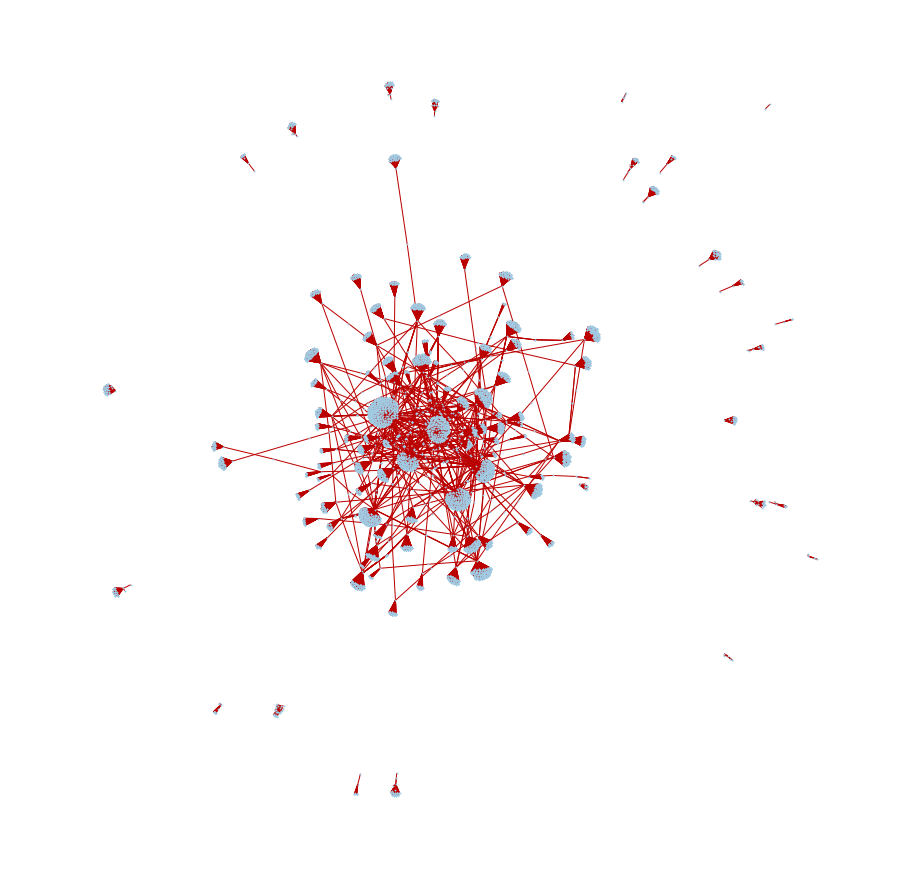

Wall time: 9min 39s


In [77]:
%%time
pos=nx.spring_layout(h)
plt.figure(figsize=(12,12))
nx.draw(h,pos,node_color='#A0CBE2',edge_color='#BB0000',width=1,with_labels=False,node_size=2)
plt.savefig("Graph_10lawsofsex.png", dpi=1000)
plt.show()

In [73]:
#Degré de ch[aque user
#degree = nx.degree(h)
degree_sequence=nx.degree(h).values()
#dmax=max(degree_sequence)

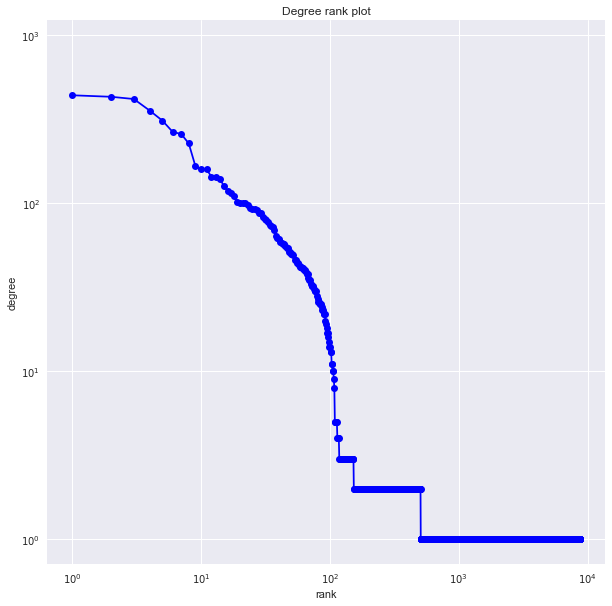

Wall time: 742 ms


In [76]:
%%time
degree_sequence=sorted(nx.degree(h).values(),reverse=True) # degree sequence

plt.figure(figsize=(10,10))
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

plt.show()

# Hashtag Graph - Features

In this section, we create all the features used to assess the virality of a given graph in the paper.

# Network Features

In [186]:
#Number of early adopters : is the set of distinct adopters in the earliest n tweets of a meme h.
#For n=50
def get_early_adopters(n, df):
    user = []
    for col in df.columns[1:(n+1)]:
        array=split_clean(df[col])
        user.append(array[0][1])
    return user

early_adopters = get_early_adopters(50, df)
print(len(set(early_adopters)), "early adopters")

39 early adopters


In [245]:
#Size of first surface
#The second surface includes uninfected users in the second surface of early adopters,
#characterizing the number of potential adopters within two steps
def get_surface(df,liste_):
    df=df[(df['user_1'].isin(liste_)) | (df["user_2"].isin(liste_))]
    df=np.unique(df)
    df = [x for x in df if x not in liste_] #on supprime les nodes infectés
    return df
first_surface = get_surface(df1, early_adopters)
print(len(first_surface), "size of first surface")

3985 size of first surface


In [249]:
#Size of second surface
#The first surface contains all the uninfected neighbors of early adopters of h.
second_surface = get_surface(df1, first_surface)
print(len(second_surface), "size of first surface")

175034 size of first surface



# Distance Features

In [272]:
#Average step distance
if nx.is_connected(h):
    average_step_distance = nx.average_shortest_path_length(h)
else:
    average_step_distance=[]
    for g in nx.connected_component_subgraphs(h):
        average_step_distance.append(nx.average_shortest_path_length(g))
average_step_distance

[5.587684196477271,
 1.9393939393939394,
 1.9393939393939394,
 1.9375,
 1.9615384615384615,
 1.8571428571428572,
 1.6666666666666667,
 1.6666666666666667,
 1.9555555555555555,
 1.8888888888888888,
 1.9230769230769231,
 1.95,
 1.9666666666666666,
 1.9523809523809523,
 1.875,
 1.8,
 1.8823529411764706,
 1.9487179487179487,
 1.9259259259259258,
 1.951219512195122,
 1.6666666666666667,
 1.9047619047619047,
 1.8181818181818181,
 1.8571428571428572,
 1.6,
 1.0]

In [288]:
#CV of step distances
#TO DO
#betweenness_centrality ?? https://networkx.github.io/documentation/development/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html

h.node[1]

KeyError: 1

In [273]:
if nx.is_connected(h):
    diameter = nx.diameter(h)
else: 
    diameter=[]
    for g in nx.connected_component_subgraphs(h):
        diameter.append(nx.diameter(g)) 
diameter

[12, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]

In [ ]:
for g in nx.connected_component_subgraphs(h):
    print(g)

# Community Features

In [269]:
#Number of infected communities


# DO NOT RUN

In [40]:
%%time
#guncontrol teamunicorns genocide  ThoughtsDuringSchool
df = extract_from_hash('10lawsofsex',"virality2013/timeline_tag.anony.dat",extended = False)
t=find_infected_vertex(df)

Wall time: 30.1 ms


In [41]:
%%time
#combination

#50 minutes to compute
master_nodes=g1.nodes()
permut = permutations(t,2)
nodes_=[]
for i,j in permut :
    if i not in master_nodes or j not in master_nodes:
        pass
    else:
        try:
            nodes_.append(nx.shortest_path(g1,source=i,target=j))
        except Exception as e:
            print('Failed at stage %s %s for reason : %s' %(i,j,e))
            
#purge
del permut
del master_nodes

NameError: name 'g1' is not defined

In [ ]:
%%time
flat=[]
for element in nodes_:
    try:
        flat.append([x for x in element])
    except Exception as e:
        print(e)

In [ ]:
def to_flat(liste_):
    flat=[]
    for element in liste_:
        try:
            flat.append([x for x in element])
        except Exception as e:
            print(e)
    return flat

In [ ]:
flat

In [ ]:
%%time
#nodes_=np.array(flat).flatten()
flat_=[val for sublist in flat for val in sublist]
#flat_=[val for sublist in flat_ for val in sublist]

In [ ]:
flat__ = sample_nodes(flat_,0.1)

In [ ]:
h=g1.subgraph(flat__)
len(h.edges())

In [ ]:
%%time

color_map=[]
size = []
for node in h:
    if node in t:
        color_map.append('red')
        size.append(40)
    else:
        color_map.append('grey')
        size.append(10)
        
options_3 = {
 'with_labels': False,
 'node_color': color_map,
 'node_size': size,
 'linewidths': 1,
 'width': 0.2,
 'alpha': 0.4
}



plt.figure(figsize=(12,12))

nx.draw_spring(h, **options_3)
plt.savefig("graph4_genocide_shortes.png", dpi=400)
plt.show()

In [33]:
ht_df[ht_df["hashtag"]=="news"]

,hashtag,count_adopters
332,news,2992


In [26]:
ht_df[ht_df["count_adopters"]==300]

,hashtag,count_adopters
3540,youaintshit,300
3541,دعاء,300
3542,getonmylevel,300
3543,sabotage,300
3544,everybody,300
3545,fucked,300
3546,ithink,300
3547,ughhh,300
3548,donthate,300
3549,10bandsiveseenlive,300


In [73]:
ht_df[ht_df["hashtag"]=="foxnews"]

,hashtag,count_adopters
2188,foxnews,496


In [74]:
df = extract_from_hash('madonna',"../../../virality2013/timeline_tag.anony.dat",extended = False)
t=find_infected_vertex(df)


In [75]:
%%time
#combination

#50 minutes to compute
master_nodes=g1.nodes()
permut = permutations(t,2)
nodes_=[]
for i,j in permut :

    try:
        nodes_.append(nx.shortest_path(g1,source=i,target=j))
    except Exception as e:
        print('Failed at stage %s %s for reason : %s' %(i,j,e))
            
#purge
del permut
del master_nodes
del df

Failed at stage 489472 595496 for reason : The node 595496 is not in the graph.
Failed at stage 489472 597659 for reason : The node 597659 is not in the graph.
Failed at stage 489472 599201 for reason : The node 599201 is not in the graph.
Failed at stage 489472 605888 for reason : The node 605888 is not in the graph.
Failed at stage 489472 600791 for reason : The node 600791 is not in the graph.
Failed at stage 489472 598303 for reason : The node 598303 is not in the graph.
Failed at stage 489472 596341 for reason : The node 596341 is not in the graph.
Failed at stage 489472 597374 for reason : The node 597374 is not in the graph.
Failed at stage 489472 606141 for reason : The node 606141 is not in the graph.
Failed at stage 425473 595496 for reason : The node 595496 is not in the graph.
Failed at stage 425473 597659 for reason : The node 597659 is not in the graph.
Failed at stage 425473 599201 for reason : The node 599201 is not in the graph.
Failed at stage 425473 605888 for reason

In [76]:
flat=[]
for element in nodes_:
    try:
        flat.append([x for x in element])
    except Exception as e:
        print(e)
flat_=[val for sublist in flat for val in sublist]
h=g1.subgraph(flat_)
len(h.edges())

55159

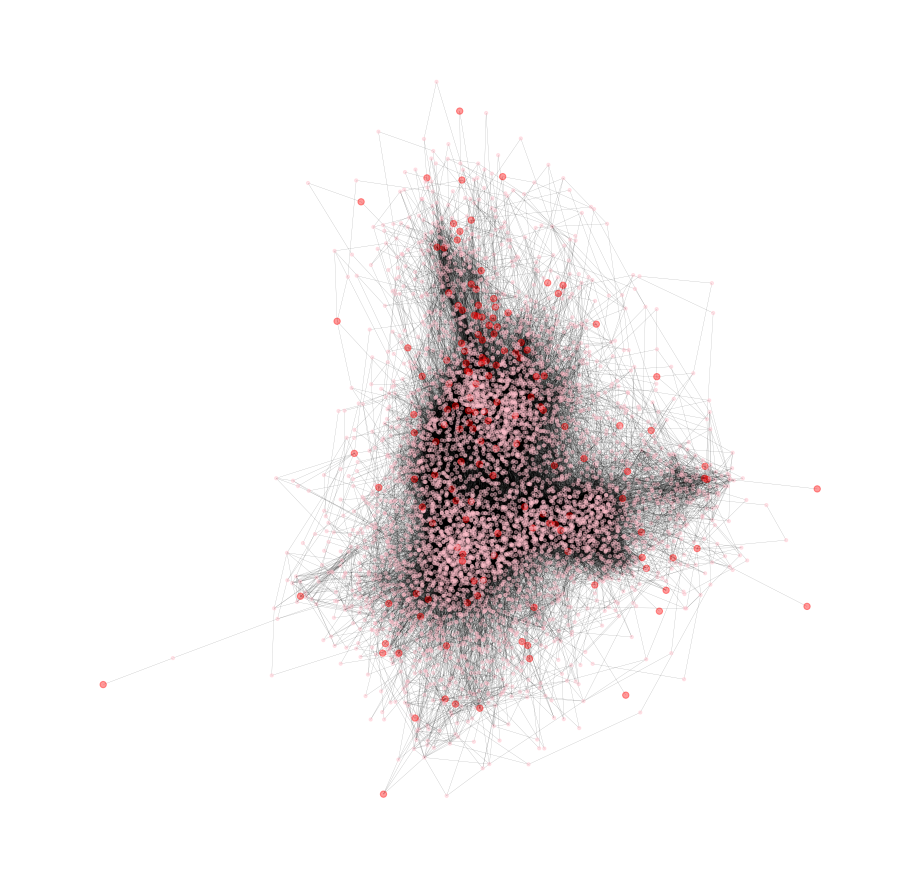

CPU times: user 1min 39s, sys: 60 ms, total: 1min 39s
Wall time: 1min 39s


In [77]:
%%time

color_map=[]
size = []
for node in h:
    if node in t:
        color_map.append('red')
        size.append(40)
    else:
        color_map.append('pink')
        size.append(10)
        
options_3 = {
 'with_labels': False,
 'node_color': color_map,
 'node_size': size,
 'linewidths': 1,
 'width': 0.2,
 'alpha': 0.4
}



plt.figure(figsize=(12,12))

nx.draw_spring(h, **options_3)
plt.savefig("graph4_madona_shortes.png", dpi=400)
plt.show()

In [78]:
%%time
df = extract_from_hash('foxnews',"../../../virality2013/timeline_tag.anony.dat",extended = False)
t2=find_infected_vertex(df)
master_nodes=g1.nodes()
permut = permutations(t2,2)
nodes_=[]
for i,j in permut :

    try:
        nodes_.append(nx.shortest_path(g1,source=i,target=j))
    except Exception as e:
        print('Failed at stage %s %s for reason : %s' %(i,j,e))
            
#purge
del permut
del master_nodes
del df

Failed at stage 123904 597427 for reason : The node 597427 is not in the graph.
Failed at stage 123904 599242 for reason : The node 599242 is not in the graph.
Failed at stage 123904 602722 for reason : The node 602722 is not in the graph.
Failed at stage 123904 602395 for reason : The node 602395 is not in the graph.
Failed at stage 123904 596803 for reason : The node 596803 is not in the graph.
Failed at stage 123904 597424 for reason : The node 597424 is not in the graph.
Failed at stage 123904 596434 for reason : The node 596434 is not in the graph.
Failed at stage 234155 597427 for reason : The node 597427 is not in the graph.
Failed at stage 234155 599242 for reason : The node 599242 is not in the graph.
Failed at stage 234155 602722 for reason : The node 602722 is not in the graph.
Failed at stage 234155 602395 for reason : The node 602395 is not in the graph.
Failed at stage 234155 596803 for reason : The node 596803 is not in the graph.
Failed at stage 234155 597424 for reason

In [79]:
flat2=[]
for element in nodes_:
    try:
        flat2.append([x for x in element])
    except Exception as e:
        print(e)
flat_2=[val for sublist in flat2 for val in sublist]
h2=g1.subgraph(flat_2)
len(h2.edges())

56957

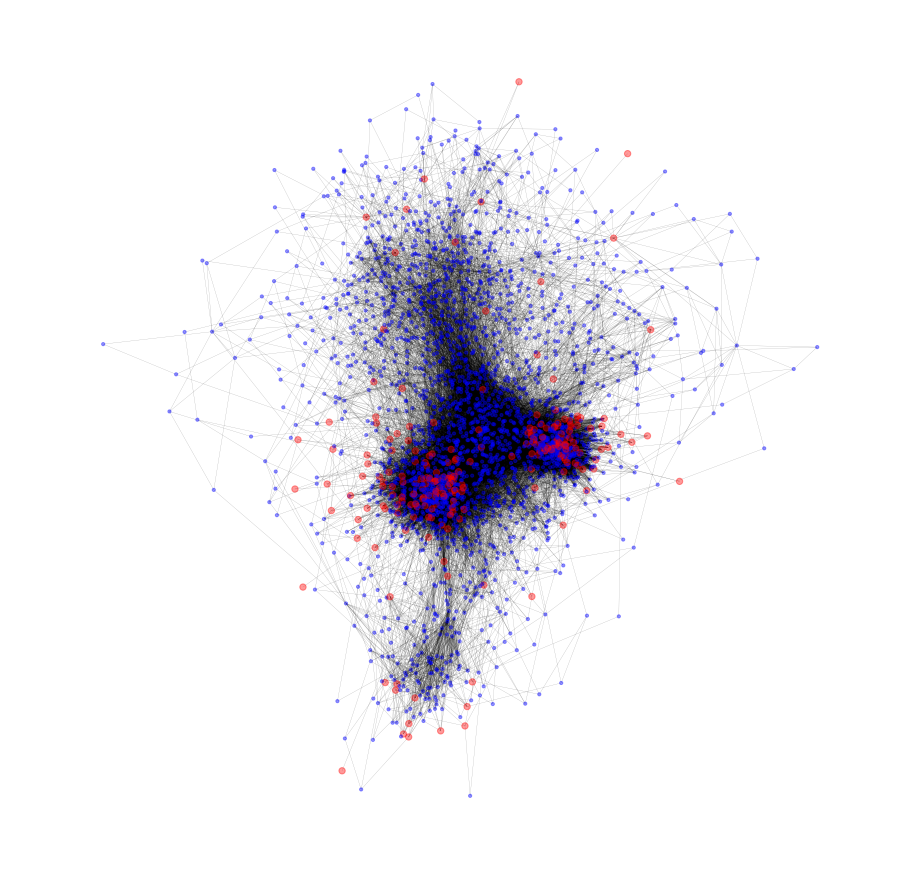

CPU times: user 39 s, sys: 16 ms, total: 39 s
Wall time: 39 s


In [80]:
%%time

color_map=[]
size = []
for node in h2:
    if node in t2:
        color_map.append('red')
        size.append(40)
    else:
        color_map.append('blue')
        size.append(10)
        
options_3 = {
 'with_labels': False,
 'node_color': color_map,
 'node_size': size,
 'linewidths': 1,
 'width': 0.2,
 'alpha': 0.4
}



plt.figure(figsize=(12,12))

nx.draw_spring(h2, **options_3)
plt.savefig("graph4_xnewsfo_shortes.png", dpi=400)
plt.show()

In [81]:
%%time
composed = nx.compose(h,h2)

CPU times: user 212 ms, sys: 20 ms, total: 232 ms
Wall time: 224 ms


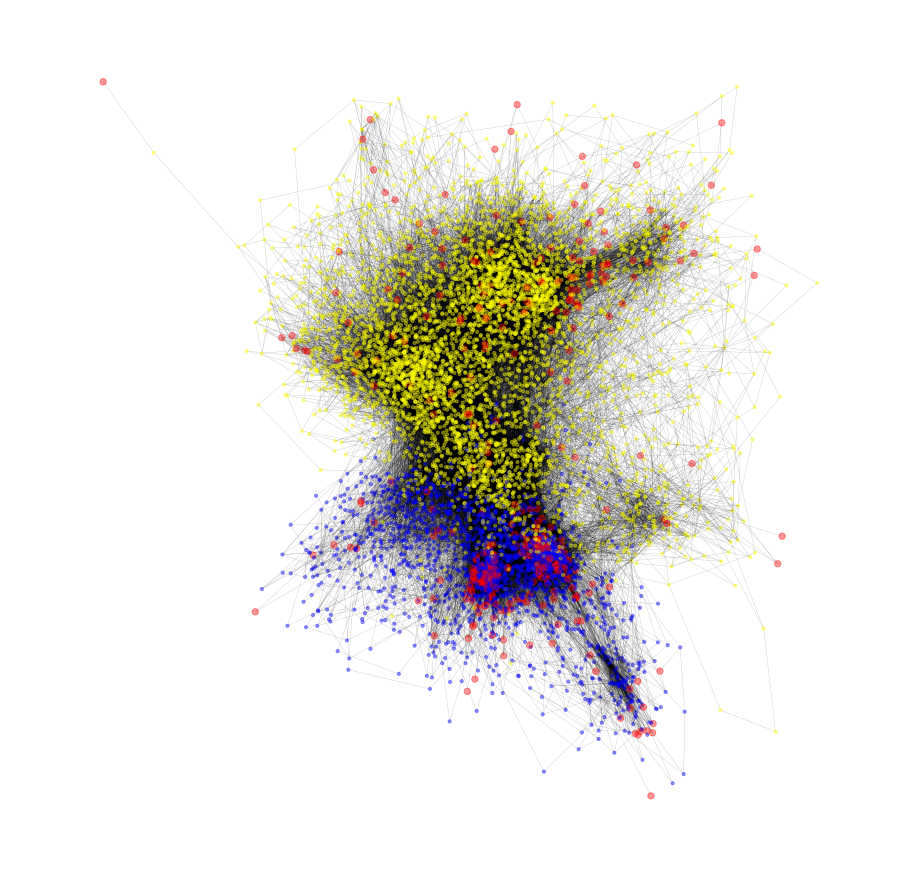

CPU times: user 2min 57s, sys: 88 ms, total: 2min 58s
Wall time: 2min 57s


In [84]:
%%time
color_map=[]
size = []
for node in composed:
    if node in t or node in t2:
        color_map.append('red')
        size.append(40)
    elif node in h:
        color_map.append('yellow')
        size.append(10)
    elif node in h2:
        color_map.append('blue')
        size.append(10)
        
options_3 = {
 'with_labels': False,
 'node_color': color_map,
 'node_size': size,
 'linewidths': 1,
 'width': 0.2,
 'alpha': 0.4
}



plt.figure(figsize=(12,12))

nx.draw_spring(composed, **options_3)
plt.savefig("graph4_madona-foxnews_shortes1.png", dpi=400)
plt.show()